# CNN Deep Learning Classifier with Tensorflow and Keras

In [3]:
import tensorflow
print (tensorflow.__version__)

from keras import backend as K

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


Using TensorFlow backend.


In [4]:
# Helper function
def load_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    c = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                features.append(img)
                labels = np.append(labels, c)
            c = c + 1
    features = np.array(features)
    
    return features, labels, classnames

In [5]:
# Prepare the image data
features, labels, classnames = load_data('resized_images')
features.shape

(2122, 128, 128, 3)

In [6]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

#Format features
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

# Format labels
y_train = np_utils.to_categorical(y_train, len(classnames))
y_train = y_train.astype('float32')
y_test = np_utils.to_categorical(y_test, len(classnames))
y_test = y_test.astype('float32')

In [7]:
# Train a CNN classifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import to_categorical

model = Sequential()
model.add(Conv2D(32, (6, 6), input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(len(classnames), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
num_epochs = 20
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=64, validation_data=(x_test, y_test))

Train on 1485 samples, validate on 637 samples
Epoch 1/20
1485/1485 [==============================] - 8s 5ms/step - loss: 2.2549 - acc: 0.2458 - val_loss: 1.9031 - val_acc: 0.4788
Epoch 2/20
1485/1485 [==============================] - 2s 1ms/step - loss: 1.3208 - acc: 0.6013 - val_loss: 0.9100 - val_acc: 0.7410
Epoch 3/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.8023 - acc: 0.7596 - val_loss: 0.5926 - val_acc: 0.8022
Epoch 4/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.6588 - acc: 0.7758 - val_loss: 0.5543 - val_acc: 0.8116
Epoch 5/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.5037 - acc: 0.8215 - val_loss: 0.4785 - val_acc: 0.8305
Epoch 6/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.4600 - acc: 0.8391 - val_loss: 0.4406 - val_acc: 0.8556
Epoch 7/20
1485/1485 [==============================] - 2s 1ms/step - loss: 0.4084 - acc: 0.8606 - val_loss: 0.4499 - val_acc: 0.8462
Epoch 8/20
1485

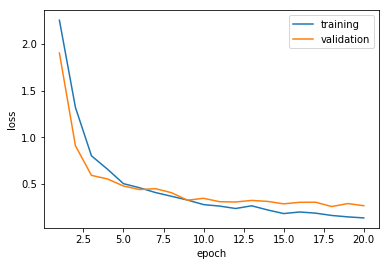

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

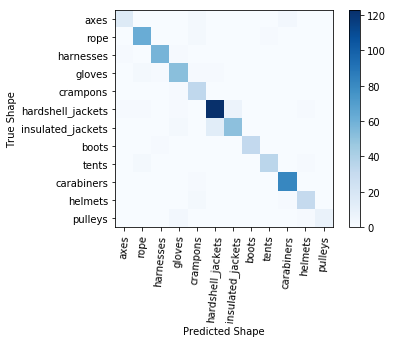

In [9]:
#Keras doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()


In [10]:
def predict_image(classifier, img):
    import numpy as np
    
    # Flatten the image data to correct feature format
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the classifier to predict the class
    predicted_class = classifier.predict(imgfeatures)
    i = np.argmax(predicted_class, axis=1)
    return i

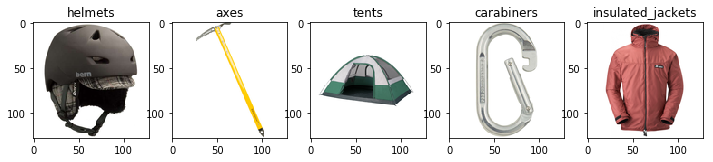

In [11]:
# Resize image
def resize_image(img, size):
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg

# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    #pre-process the image so it matches the training set
    img = np.array(resize_image(img, size))
    class_idx = predict_image(model, img)
    class_name = classnames[class_idx[0]]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)